In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import dirichlet
from scipy.stats import gamma
from scipy.stats import multinomial
from scipy.stats import wishart
from scipy.stats import multivariate_normal
from scipy.stats import multinomial
import pandas as pd
import time

In this notebook, I did Bayesian inference of a Gaussian mixture model.
First, I generate data. 

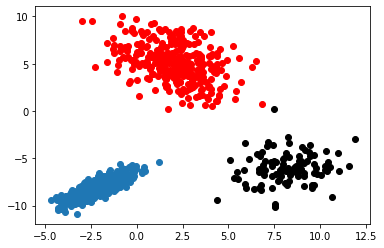

In [2]:
true_mean = np.array([[-2,-8],
                    [8, -6],
                    [2,5]])
true_cov = np.array([[[1,.85],[.85,1]],
                   [[2,.1],[.1,3]],
                   [[3,-1.5],[-1.5,4]]])
true_ratio = [.6,.1,.3]
count=multinomial.rvs(1000, true_ratio, size=1)
x1=multivariate_normal(true_mean[0], true_cov[0]).rvs(size=count[0][0])
x2=multivariate_normal(true_mean[1], true_cov[1]).rvs(size=count[0][1])
x3=multivariate_normal(true_mean[2], true_cov[2]).rvs(size=count[0][2])
X=(np.concatenate([x1,x2,x3])).reshape(-1,2)
plt.scatter(x1[:,0],x1[:,1])
plt.scatter(x2[:,0],x2[:,1],color="black")
plt.scatter(x3[:,0],x3[:,1],color="red")

It looks like there are 3 clusters even if you didn't know how this data was generated.

In [3]:
count

array([[599, 101, 300]])

In [4]:
x1.mean(axis=0),x2.mean(axis=0),x3.mean(axis=0)

(array([-2.07005387, -8.04184219]),
 array([ 8.17932549, -6.05492035]),
 array([2.00929062, 5.13257348]))

There are 1000 observations. <br/>
599 are drawn from group 1, where the true means are [-2,-8] and sample means are [-2.07005387, -8.04184219] <br/>
101 are drawn from group 2, where the true means are [8,-6] and sample means are [ 8.17932549, -6.05492035] <br/>
300 are drawn from group 3, where the true means are [2,5] and sample means are [2.00929062, 5.13257348] <br/>

In [6]:
#Gibbs sampling
N=X.shape[0]
K=3 # # of clusters
D=X.shape[1]
mu = np.zeros((K,1,D)) #mean 
lmbd = np.zeros((K,D,D)) #precision matrix.lmbd[0,:,:] is D by D precision matrix for k=0

m = np.random.rand(D,1)
m_hat = np.random.rand(K,D,1)


beta = 1
beta_hat = np.zeros((1,K))
nu = D
nu_hat = np.zeros((1,K))
W = .001

alpha_hat = np.zeros((1,K))
alpha = np.ones((1,K)) 

for k in range(K):
    lmbd[k:,:] = np.identity(D)
    
W_hat=np.zeros((K,D,D))    
eta = np.zeros((N,K))
pi = np.zeros((1,K))+1/K
s=np.zeros((N,K)) 
max_iter=220
warmup = 20
mu_history=np.zeros((max_iter,K,1,D))
s_history = np.zeros((max_iter,N,K))
lmbd_history = np.zeros((max_iter,K,D,D))
pi_history = np.zeros((max_iter,1,K))
start = time.time()
for i in range(max_iter):
    print(i, end=" ")
    for n in range(N):
        
        for k in range(K):
            tmp=-1/2*(X[n,:]-mu[k,:,:]).dot(lmbd[k,:,:]).dot((X[n,:]-mu[k,:,:]).T) 
            tmp+= 1/2 * np.log(np.linalg.det(lmbd[k,:,:]))+ np.log(pi[0][k])
            tmp_e = np.exp(tmp[0])[0]
            eta[n,k]=(tmp_e)
        eta[n,:]=(eta[n,:]/eta[n,:].sum()).round(6)
        s[n] = multinomial.rvs(n=1, p=eta[n], size=1) 
    s_history[i,:,:] = s
    
        
  
    inv_W_hat = np.zeros((K,D,D))
    for k in range(K):
        #sample lambda (precision)
        for n in range(N):
            inv_W_hat[k,:,:] += s[n,k] * X[n,:].reshape(D,-1) * X[n,:].reshape(1,-1)
            
        inv_W_hat[k,:,:] +=  beta * m.dot(m.T) - beta_hat[:,k] *  m_hat[k,:,:].dot(m_hat[k,:,:].T) + 1/W
        W_hat[k,:,:] = np.linalg.inv(inv_W_hat[k,:,:])
        nu_hat[:,k] = s[:,k].sum() + nu
        lmbd[k,:,:] = wishart.rvs(df = nu_hat[:,k][0], scale = W_hat[k,:,:]) 
        
        #sample mu 
        beta_hat[:,k] = s[:,k].sum() + beta
        m_hat[k,:,:] = ((s[:,k].T.dot(X)).reshape(D,1)+beta*m)/beta_hat[:,k]
        mu[k,:,:] = multivariate_normal.rvs(np.array([m_hat[k,:,:][0][0],m_hat[k,:,:][1][0]]), np.linalg.inv(beta_hat[:,k] * lmbd[k,:,:]))
    lmbd_history[i,:,:,:] = lmbd
    mu_history[i,:,:,:] = mu.copy()
    alpha_hat = s.sum(axis=0) + alpha
    pi = dirichlet.rvs(alpha_hat[0])
    pi_history[i,:,:]= pi.copy()

end = time.time()
t= end - start
print("\ntime:",np.round(t,2),"sec")

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 
time: 58.19 sec


In [7]:
mu_history[warmup:,:,:,:].mean(axis=0),true_mean

(array([[[ 2.00471755,  5.09271792]],
 
        [[-2.06666842, -8.02833138]],
 
        [[ 8.13519596, -5.99372296]]]),
 array([[-2, -8],
        [ 8, -6],
        [ 2,  5]]))

These are posterior means and true means. The orders are not necessarily the same. <br/>
The first 50 MCMC samples are discarded (warm up). <br/>
The posterior means are close to the true means.


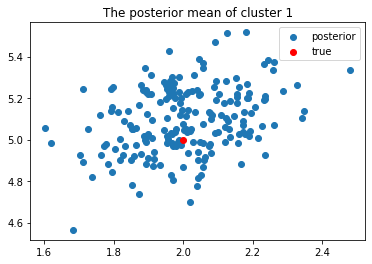

In [8]:
i,j,k = 2,0,1
plt.scatter(mu_history[warmup:,0,0,0],mu_history[warmup:,0,0,1])
plt.scatter(true_mean[i][0],true_mean[i][1],color="red")
plt.legend(["posterior","true"])
plt.title("The posterior mean of cluster 1")
plt.show()

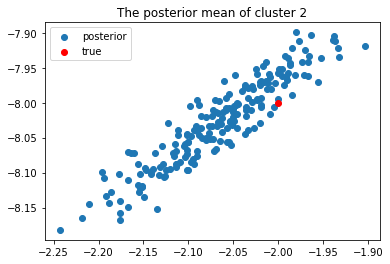

In [9]:
plt.scatter(mu_history[warmup:,1,0,0],mu_history[warmup:,1,0,1])
plt.scatter(true_mean[j][0],true_mean[j][1],color="red")
plt.legend(["posterior","true"])
plt.title("The posterior mean of cluster 2")
plt.show()

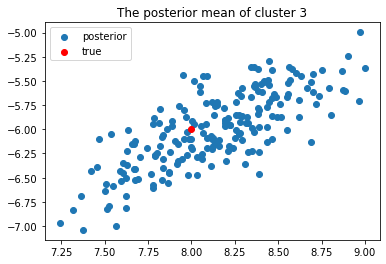

In [10]:
plt.scatter(mu_history[warmup:,2,0,0],mu_history[warmup:,2,0,1])
plt.scatter(true_mean[k][0],true_mean[k][1],color="red")
plt.legend(["posterior","true"])
plt.title("The posterior mean of cluster 3")
plt.show()

In [11]:
CI0 = np.round(np.percentile(pi_history[warmup:,0,0], (2.5, 97.5)),4)
CI1 = np.round(np.percentile(pi_history[warmup:,0,1], (2.5, 97.5)),4)
CI2 = np.round(np.percentile(pi_history[warmup:,0,2], (2.5, 97.5)),4)
CI0,CI1,CI2

(array([0.2735, 0.3294]), array([0.5683, 0.6261]), array([0.0814, 0.1203]))

In [12]:
pd.DataFrame({ "True ratio":[.6,.3,.1],
             "95% CI of ratio":[CI1,CI0,CI2]})

,True ratio,95% CI of ratio
0,0.6,"[0.5683, 0.6261]"
1,0.3,"[0.2735, 0.3294]"
2,0.1,"[0.0814, 0.1203]"


All 95% credible intervals capture the true ratios

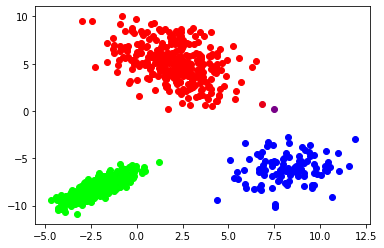

In [13]:
for n in range(N):
    plt.scatter(X[n,0],X[n,1],color=s_history[warmup:,n,:].mean(axis=0))
    

This is a visualization of 3 clusters for the generated data by using RGB. <br/>
The purple dot is not 4th cluster, but it indicates that it is unclear whether the observation belongs to the red cluster or blue cluster.
